In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dc_stat_think as dcst
import numpy as np

In [2]:
df=pd.read_csv('earthquakes.csv',parse_dates=['time'],index_col='time')

print(df.columns)


Index(['latitude', 'longitude', 'depth', 'mag', 'magType', 'gap', 'dmin',
       'rms', 'id', 'place'],
      dtype='object')


(array([18262., 18322., 18383., 18444., 18506., 18567., 18628., 18687.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

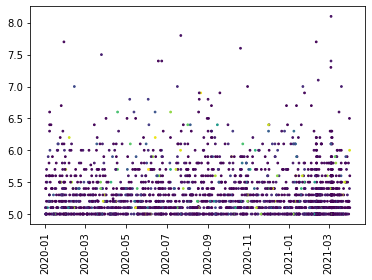

In [3]:
plt.scatter(data=df,x=df.index,y='mag',c='depth',s=3)
plt.xticks(rotation=90)

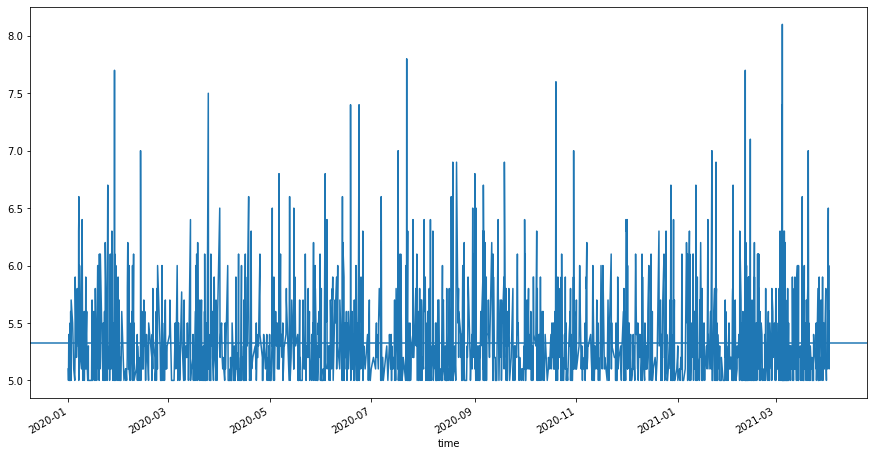

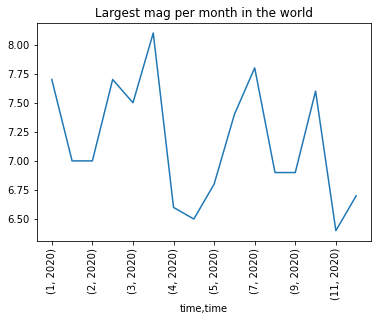

In [4]:
#grouped=df.groupby(df.index)['mag'].agg({'min','max'})
#print(grouped)
#grouped.plot()
mean_mag=df['mag'].mean()
plt.figure(figsize=(15,8))
df['mag'].plot()
plt.axhline(mean_mag)
plt.show()


grouped=df.groupby(by=[df.index.month, df.index.year])['mag'].max()
grouped.plot()
plt.xticks(rotation=90)
plt.title('Largest mag per month in the world')
plt.show()


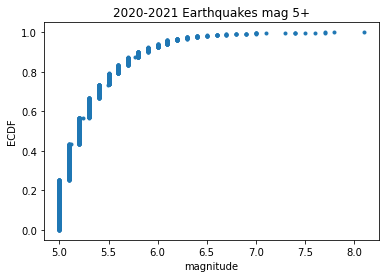

In [5]:
mags=df['mag']
# Make the plot
plt.plot(*dcst.ecdf(mags),marker='.',linestyle='none')

# Label axes and show plot

plt.xlabel('magnitude')
plt.ylabel('ECDF')
plt.title('2020-2021 Earthquakes mag 5+')
plt.show()



In [6]:
mean_earthquake=np.mean(df['mag'])
bs_earthquake = dcst.draw_bs_reps(df['mag'], np.mean, size=10000)

conf_int_earthquake = np.percentile(bs_earthquake, [2.5,97.5])

#print(conf_int_earthquake[0],conf_int_earthquake[1])
# Print the results
print("earthquake mag mean {} confidence interval[{} {}]".format(mean_earthquake, conf_int_earthquake[0],conf_int_earthquake[1]))

earthquake mag mean 5.328070017953322 confidence interval[5.3117361983842475 5.344421117594292]


In [7]:
def b_value(mags,mt,perc=[2.5,97.5],n_reps=None):
    """Compute the b-value and optionally its confidence interval."""
    # Extract magnitudes above completeness threshold: m
    m = mags[mags >= mt]

    # Compute b-value: b
    b = (np.mean(m)-mt) * np.log(10)

    # Draw bootstrap replicates
    if n_reps is None:
        return b
    else:
        m_bs_reps = dcst.draw_bs_reps(m,np.mean,size=n_reps)

        # Compute b-value from replicates: b_bs_reps
        b_bs_reps = (m_bs_reps - mt) * np.log(10)

        # Compute confidence interval: conf_int
        conf_int = np.percentile(b_bs_reps,perc)
    
        return b, conf_int


theortical versus ecdf of earthquakes


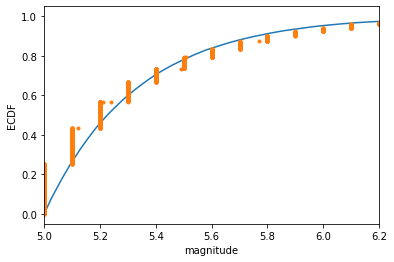


b-value: 0.76
95% conf int: [0.72, 0.79]

The b-value of about 1 is typical for regions along fault zones.


In [8]:
print('theortical versus ecdf of earthquakes')
mt=5
# Compute b-value and confidence interval
b, conf_int = b_value(mags, mt, perc=[2.5, 97.5], n_reps=10000)

# Generate samples to for theoretical ECDF
m_theor = np.random.exponential(b/np.log(10), size=100000) + mt

# Plot the theoretical CDF
_ = plt.plot(*dcst.ecdf(m_theor))

# Plot the ECDF (slicing mags >= mt)
_ = plt.plot(*dcst.ecdf(mags[mags >= mt]), marker='.', linestyle='none')

# Pretty up and show the plot
_ = plt.xlabel('magnitude')
_ = plt.ylabel('ECDF')
_ = plt.xlim(5, 6.2)
plt.show()

# Report the results
print("""
b-value: {0:.2f}
95% conf int: [{1:.2f}, {2:.2f}]""".format(b, *conf_int))

print("\nThe b-value of about 1 is typical for regions along fault zones.")

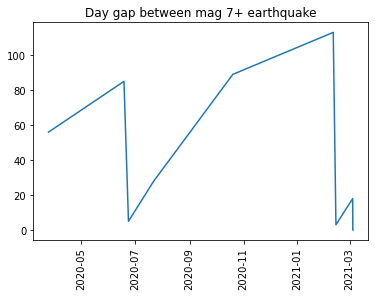

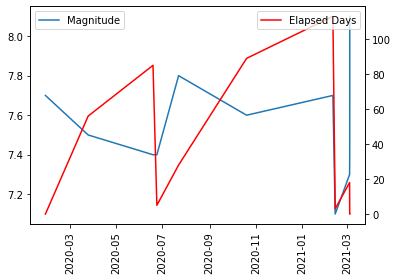

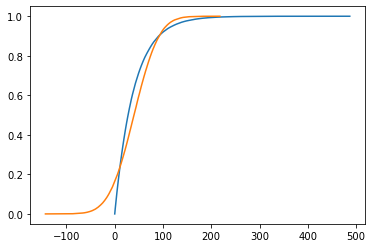

In [67]:
events=df[df.mag >7]
events=events.sort_index()

index=0
#dates ascending False
events['previous']=events.index
for key,item in events.iterrows():
    if index>0:
        events.loc[key,'previous']=events.index.values[index-1]
        events.loc[key,'time_delta']=events.index.values[index]-events.index.values[index-1]
        #print(events.index.values[index],events.index.values[index-1])
    index+=1

#print(events)
time_delta=events['time_delta'].apply(lambda x:x.days)

plt.plot(time_delta)
plt.title('Day gap between mag 7+ earthquake')
plt.xticks(rotation=90)
plt.show()

events['elapsed_days']=events['time_delta'].apply(lambda x: np.nan_to_num(x.days))

X=events[['latitude','longitude','elapsed_days','depth']]
y=np.nan_to_num(events['mag'])
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
#predict_days=np.linspace(min(events['elapsed_days']),max(events['elapsed_days'])).reshape(-1,1)
#predict_depth=np.linspace(min(events['depth']),max(events['depth'])).reshape(-1,1)
lr.fit(X,y)

fig, ax= plt.subplots()
ax.plot(events.index,np.nan_to_num(events['mag']))
plt.xticks(rotation=90)
plt.legend(['Magnitude'])
twin_ax=ax.twinx()
twin_ax.plot(events.index,events['elapsed_days'],color='red')
plt.legend(['Elapsed Days'],loc=1)
plt.show()


mean_time_gap = np.mean(time_delta)
std_time_gap=np.std(time_delta)

# get alot of samples
time_gap_exp = np.random.exponential(mean_time_gap, size=100000)

time_gap_norm = np.random.normal(
    mean_time_gap, std_time_gap, size=100000
)

_= plt.plot(*dcst.ecdf(time_gap_exp))
_= plt.plot(*dcst.ecdf(time_gap_norm))
plt.show()

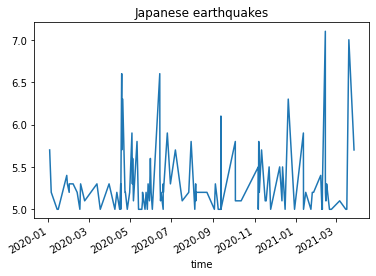

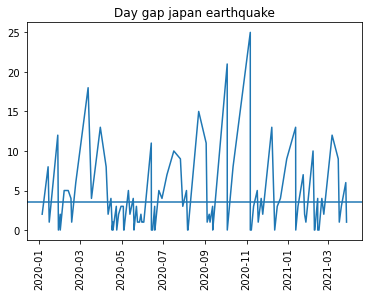

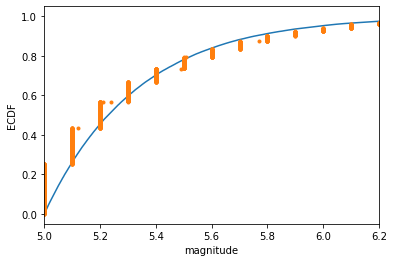


b-value: 0.76
95% conf int: [0.72, 0.79]

The b-value of about 1 is typical for regions along fault zones.


In [150]:
japan_filter = df.place.str.contains('Japan')

japan=df[japan_filter]
japan=japan.sort_index()

japan['mag'].plot()
plt.title('Japanese earthquakes')
plt.show()


japan['previous']=japan.index
index=0
for key,item in japan.iterrows():
    if index>0:
        japan.loc[key,'previous']=japan.index.values[index-1]
        japan.loc[key,'time_delta']=japan.index.values[index]-japan.index.values[index-1]
        #print(events.index.values[index],events.index.values[index-1])
    index+=1

#print(events)
time_delta=japan['time_delta'].apply(lambda x:x.days)

time_gap=time_delta
mean_time_gap=np.mean(time_delta)
std_time_gap=np.std(time_delta)

plt.plot(time_delta)
plt.title('Day gap japan earthquake')
plt.axhline(mean_time_gap)
plt.xticks(rotation=90)
plt.show()

plt.clf()
mag=japan.mag

mt=5
# Compute b-value and confidence interval
b, conf_int = b_value(mags, mt, perc=[2.5, 97.5], n_reps=10000)

# Generate samples to for theoretical ECDF
m_theor = np.random.exponential(b/np.log(10), size=100000) + mt

# Plot the theoretical CDF
_ = plt.plot(*dcst.ecdf(m_theor))

# Plot the ECDF (slicing mags >= mt)
_ = plt.plot(*dcst.ecdf(mags[mags >= mt]), marker='.', linestyle='none')

# Pretty up and show the plot
_ = plt.xlabel('magnitude')
_ = plt.ylabel('ECDF')
_ = plt.xlim(5, 6.2)
plt.show()

# Report the results
print("""
b-value: {0:.2f}
95% conf int: [{1:.2f}, {2:.2f}]""".format(b, *conf_int))

print("\nThe b-value of about 1 is typical for regions along fault zones.")


In [151]:
def ks_stat(data1, data2):
    # Compute ECDF from data: x, y
    x,y=dcst.ecdf(data1)
    
    # Compute corresponding values of the target CDF
    cdf = dcst.ecdf_formal(x,data2)

    # Compute distances between concave corners and CDF
    D_top = y - cdf

    # Compute distance between convex corners and CDF
    D_bottom = cdf - y + 1/len(data1)

    return np.max((D_top, D_bottom))


def draw_ks_reps(n, f, args=(), size=10000, n_reps=10000):
    # Generate samples from target distribution
    x_f = f(*args,size=size)
    
    # Initialize K-S replicates
    reps = np.empty(n_reps)
    
    # Draw replicates
    for i in range(n_reps):
        # Draw samples for comparison
        x_samp = f(*args, size=n)
        
        # Compute K-S statistic
        reps[i] = dcst.ks_stat(x_samp, x_f)

    return reps







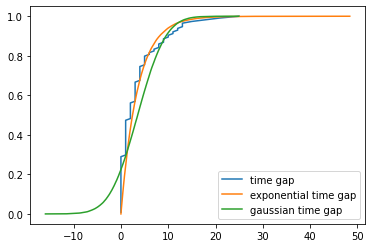

normally distributed p = 0.0
exponential distributed p = 0.0
gaussian distributed


In [152]:
time_gap_exp = np.random.exponential(mean_time_gap, size=100000)

time_gap_norm = np.random.normal(
    mean_time_gap, std_time_gap, size=100000
)

_= plt.plot(*dcst.ecdf(time_gap))
_= plt.plot(*dcst.ecdf(time_gap_exp))
_= plt.plot(*dcst.ecdf(time_gap_norm))
plt.legend(['time gap','exponential time gap','gaussian time gap'])
plt.show()


# Draw target distribution: x_f (theortical ecdf)
x_f = np.random.normal(mean_time_gap, std_time_gap, size=10000)

# Compute K-S stat: d
d = dcst.ks_stat(time_gap,x_f)

# Draw K-S replicates: reps
reps = dcst.draw_ks_reps(len(time_gap), np.random.normal, 
                         args=(mean_time_gap,std_time_gap), size=10000, n_reps=10000)

#print(reps)
# Compute and print p-value
p_val = np.sum(reps >= d) / 10000
print('normally distributed p =', p_val)

# Draw target distribution: x_f
#b, conf_int = b_value(mags, mt, perc=[2.5, 97.5], n_reps=10000)
#x_f=np.random.exponential(b/np.log(10), size=100000) + mt
x_f = np.random.exponential(mean_time_gap,  size=10000)

# Compute K-S stat: d
d = dcst.ks_stat(time_gap,x_f)

# Draw K-S replicates: reps
reps = dcst.draw_ks_reps(len(time_gap), np.random.exponential, 
                         args=(mean_time_gap,), size=10000, n_reps=10000)

#print(reps)
# Compute and print p-value
p_val = np.sum(reps >= d) / 10000
print('exponential distributed p =', p_val)

print('gaussian distributed')